In [1]:
%reset -f

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from typing import List, Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from IPython.display import display

In [2]:
DATA_PATH = "/home/alejandro/Zrive"

df = pd.read_csv(Path(DATA_PATH, "feature_frame.csv"))

In [4]:
print(df.head())

       variant_id     product_type       order_id        user_id  \
0  33826472919172  ricepastapulses  2807985930372  3482464092292   
1  33826472919172  ricepastapulses  2808027644036  3466586718340   
2  33826472919172  ricepastapulses  2808099078276  3481384026244   
3  33826472919172  ricepastapulses  2808393957508  3291363377284   
4  33826472919172  ricepastapulses  2808429314180  3537167515780   

            created_at           order_date  user_order_seq  outcome  \
0  2020-10-05 16:46:19  2020-10-05 00:00:00               3      0.0   
1  2020-10-05 17:59:51  2020-10-05 00:00:00               2      0.0   
2  2020-10-05 20:08:53  2020-10-05 00:00:00               4      0.0   
3  2020-10-06 08:57:59  2020-10-06 00:00:00               2      0.0   
4  2020-10-06 10:37:05  2020-10-06 00:00:00               3      0.0   

   ordered_before  abandoned_before  ...  count_children  count_babies  \
0             0.0               0.0  ...             0.0           0.0   
1         

In [5]:
display(df.head())
df.info()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [3]:
info_columns = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
target = "outcome"
features_cols = [col for col in df.columns if col not in info_columns and col != target]
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col
    for col in features_cols
    if col not in categorical_cols and col not in binary_cols
]

print(f"Number of categorical variables : {len(categorical_cols)}")
print(f"Number of binary variables : {len(binary_cols)}")
print(f"Number of numerical variables : {len(numerical_cols)}")
print(f"Number of info variables : {len(info_columns)}")

Number of categorical variables : 2
Number of binary variables : 4
Number of numerical variables : 15
Number of info variables : 5


Requirements:
We are only interested in users that purchases the item along with at least other 4
(minimum 5 items basket), since shipping costs for a single or few items can be
higher than the gross margin coming from it.

In [4]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    """We filtered the dataframe to only include orders with at least 5 products purchased"""
    orders_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = orders_size[orders_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]


df_selected = (
    df.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

To create a model, first we have to split the data. The two main considerations we have to acknowledge are: information leakage and class imbalances.
With this specific data, since we are dealing in some way with time-series data(we have data from 2020 to 2021), it makes sense to do a temporal split so that we respect the chronological order of the data and prevent information leakage. 
Regarding, class imbalances, as we are not randomizing the train-test split, we suppose that the class distribution is similar in both sets. If this weren't the case, we could use stratified sampling to ensure that the class distribution is similar in both sets.

In [8]:
daily_orders = df_selected.groupby("order_date").order_id.nunique()
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

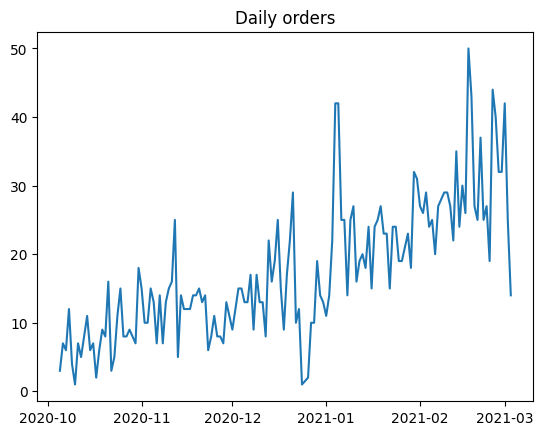

In [9]:
plt.plot(daily_orders, label="daily orders")
plt.title("Daily orders")

In [10]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders < 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders < 0.9].idxmax()
print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Validation since:", train_val_cutoff)
print("Validation until:", val_test_cutoff)
print("Test since:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Validation since: 2021-02-04
Validation until: 2021-02-22
Test since: 2021-02-22
Test until: 2021-03-03


In [11]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date > train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

In [12]:
display(train_df.outcome.value_counts(normalize=True))
display(val_df.outcome.value_counts(normalize=True))
test_df.outcome.value_counts(normalize=True)

outcome
0.0    0.984908
1.0    0.015092
Name: proportion, dtype: float64

outcome
0.0    0.98648
1.0    0.01352
Name: proportion, dtype: float64

outcome
0.0    0.987126
1.0    0.012874
Name: proportion, dtype: float64

## Base model

In order to know if we are following the right path, we will start by creating a simple model that will serve as a baseline and benchmark for future models.  we will take a simple predictor as the baseline(column: `Global popularity`). Since we are dealing with a binary classification problem (purchased or not purchased), the metrics used will be: Precision-Recall curve and AUC-ROC curve. The Precision-Recall curve it's a specially good metric to use when the classes are imbalanced, as is the case here. All these metrics are based on the infamous confusion matrix.

In [13]:
def plot_metrics(
    model_name: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    figure: Tuple[matplotlib.figure.Figure, np.array] = None,
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, ax = figure
    ax[0].plot(recall_, precision_, label=f"{model_name} (AUC = {pr_auc:.2f})")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall curve")
    ax[0].legend(loc="best")

    ax[1].plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC curve")
    ax[1].legend(loc="best")

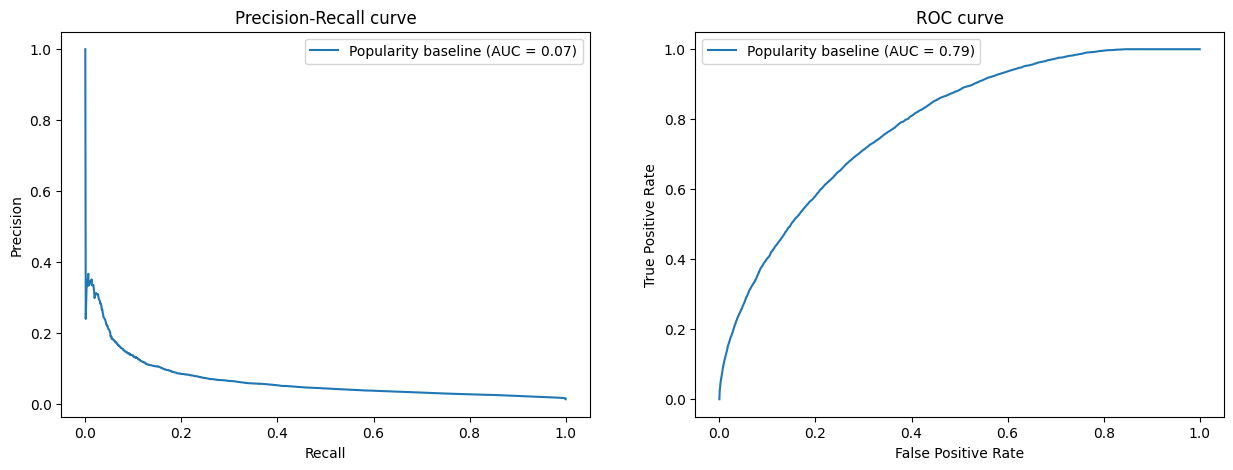

In [14]:
plot_metrics(
    "Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[target]
)

## Training models

We will be following a increasing complexity approach, so we will start with a simple model and then we will try to improve it and compare the results with the others models. 

In [15]:
def feature_label_split(
    df: pd.DataFrame, target: str
) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(columns=[target]), df[target]


X_train, y_train = feature_label_split(train_df, target)
X_val, y_val = feature_label_split(val_df, target)
X_test, y_test = feature_label_split(test_df, target)

First, let's start a simple logistic model without doing any one hot encoding or pca. Just numerical and binary columns will be use.

In [16]:
train_cols = numerical_cols + binary_cols

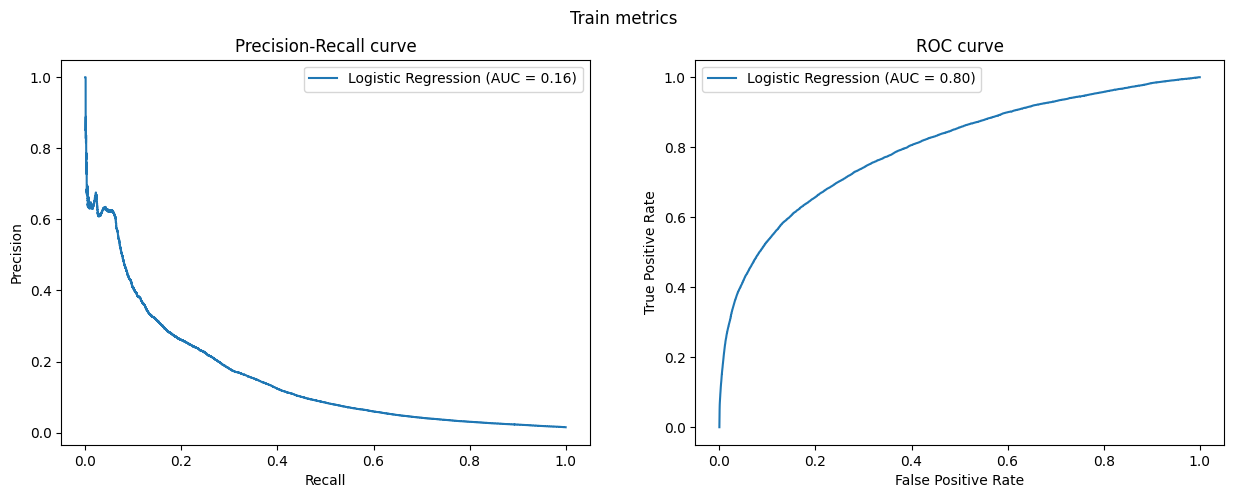

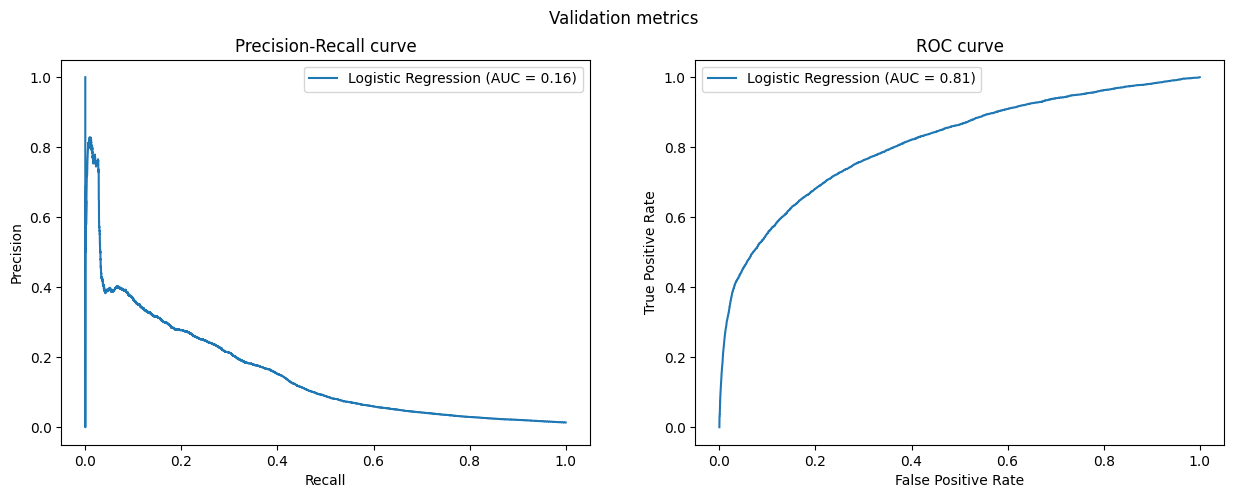

In [17]:
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 5))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))
fig2.suptitle("Validation metrics")
lr = Pipeline(
    steps=[("scaler", StandardScaler()), ("classifier", LogisticRegression())]
)
lr.fit(X_train[train_cols], y_train)
train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    "Logistic Regression", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
)
val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
plot_metrics("Logistic Regression", val_proba, y_val, figure=(fig2, ax2))

Let's know try with ridge or lasso regularization to see if we can improve the model. StandardScaler() will be use to remove scale effects from every feature. Thus, features with large values won't dominate the model.

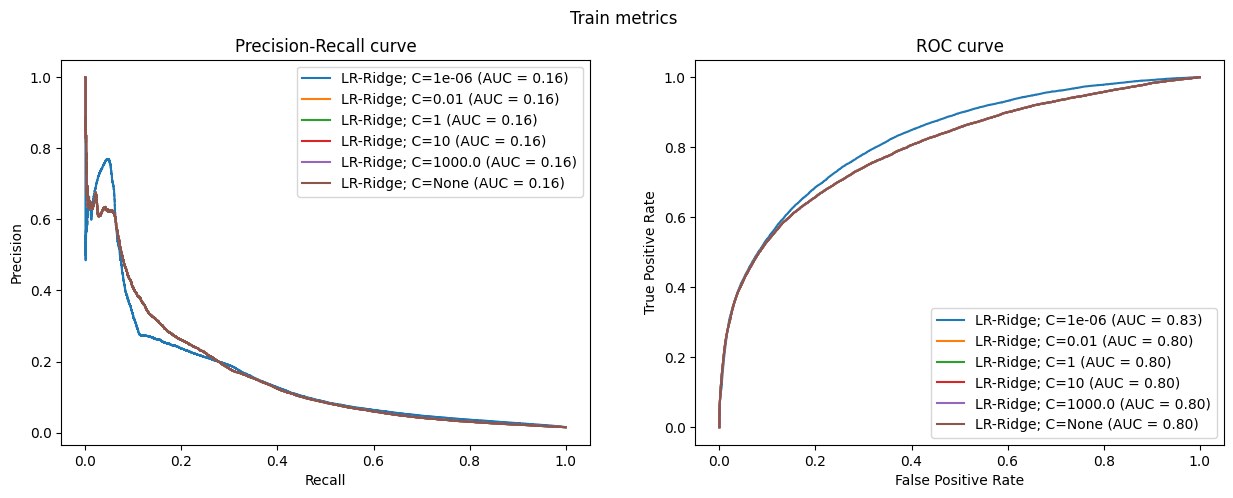

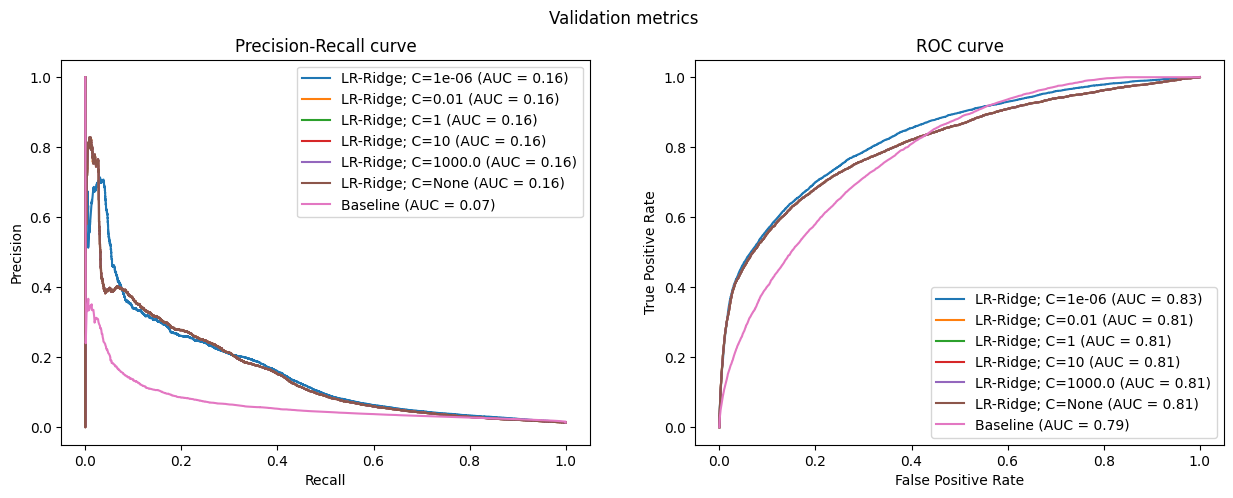

In [18]:
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 5))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))
fig2.suptitle("Validation metrics")

for c in [1e-6, 1e-2, 1, 10, 1e3, None]:
    lr = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            (
                "classifier",
                LogisticRegression(penalty="l2" if c else None, C=c if c else 1.0),
            ),
        ]
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"LR-Ridge; C={c}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )
    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"LR-Ridge; C={c}", val_proba, y_val, figure=(fig2, ax2))

plot_metrics(
    f"Baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[target],
    figure=(fig2, ax2),
)

- The logistic regression model is giving better results than the baseline model. Higher PR AUC and ROC AUC.
- However, the ridge regularization is not improving the model due to the huge amount of rows present in the dataset.
- The training and validation metrics are very similar, which is a good sign that the model is not overfitting.

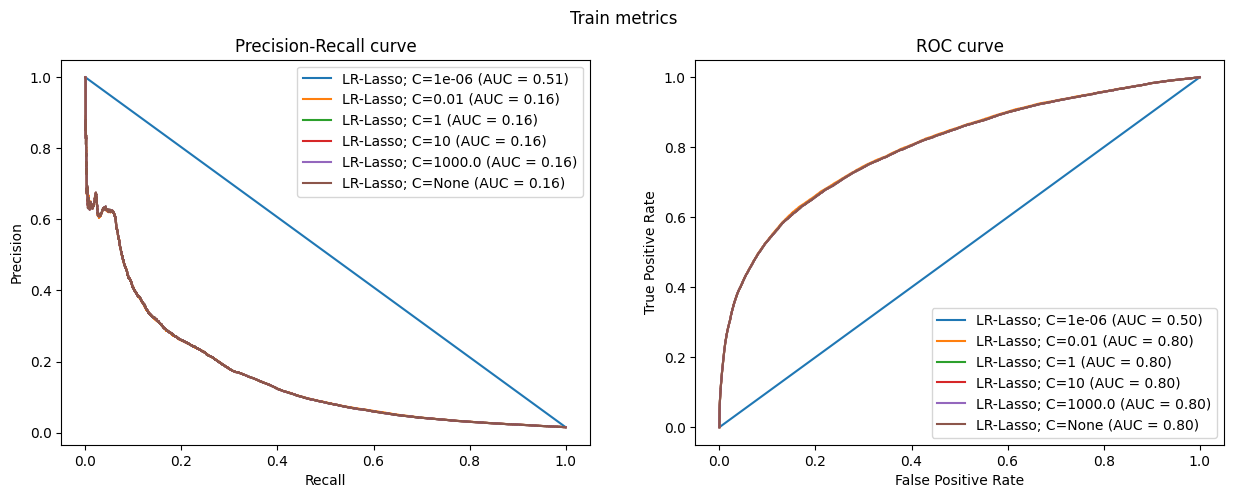

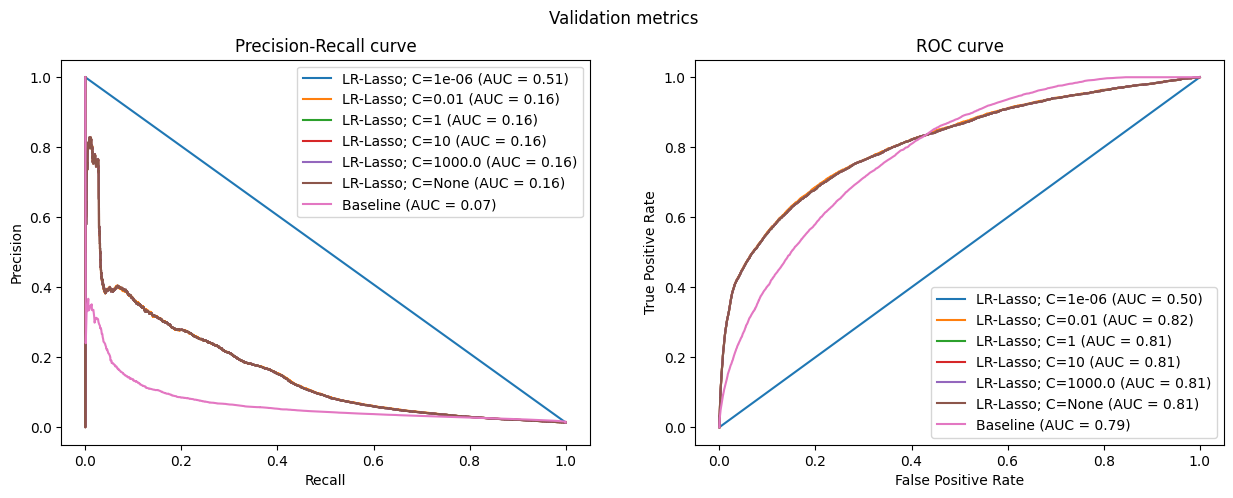

In [19]:
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 5))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))
fig2.suptitle("Validation metrics")

for c in [1e-6, 1e-2, 1, 10, 1e3, None]:
    lr = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            (
                "classifier",
                LogisticRegression(
                    penalty="l1" if c else None, C=c if c else 1.0, solver="saga"
                ),
            ),
        ]
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"LR-Lasso; C={c}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )
    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"LR-Lasso; C={c}", val_proba, y_val, figure=(fig2, ax2))

plot_metrics(
    f"Baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[target],
    figure=(fig2, ax2),
)

- Large regularization (Blue plot) makes the trivial case: Random guessing.
- As in the case with ridge regularization, lasso is very similar it isn't overfitting but it's not improving the model.

In [20]:
lr.named_steps["classifier"].coef_[0]

array([-0.10468852, -0.36984836,  0.02018514,  0.27601037,  0.00475515,
       -0.00695367, -0.00070619,  0.0289681 , -0.00286916, -0.01423698,
       -0.1546069 ,  0.01178772,  0.0707134 , -0.06502468,  0.03025022,
        0.40549841,  0.15320255,  0.00793612,  0.04118143])

Let's now evaluate the importance of each variable in the model.

In [21]:
lr = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(penalty="l2", C=1e-6)),
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["classifier"].coef_[0]),
        "regularization": ["l2"] * len(train_cols),
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=False)

lr = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(penalty="l1", C=1e-4, solver="saga")),
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["classifier"].coef_[0]),
        "regularization": "l1",
    }
)
lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=False)

In [22]:
lr_coeffs = pd.concat([lr_coeff_l2, lr_coeff_l1])
lr_coeffs["features"] = pd.Categorical(lr_coeffs["features"])
lr_coeffs = lr_coeffs.sort_values("importance")
order_columns = lr_coeff_l2.sort_values("importance", ascending=False)["features"]

<Axes: xlabel='importance', ylabel='features'>

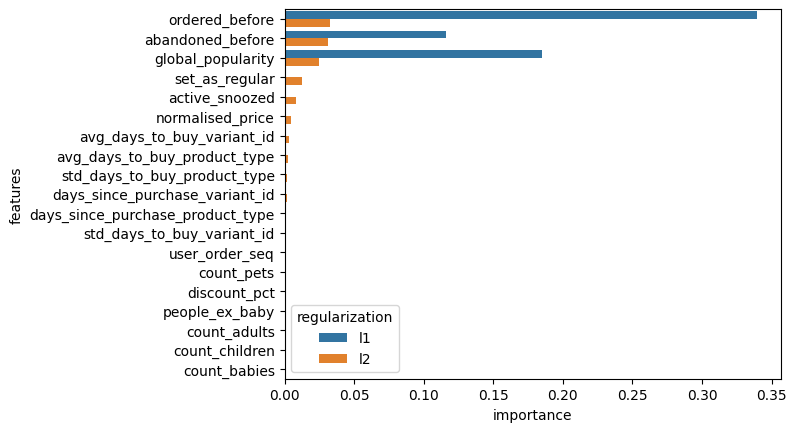

In [23]:
sns.barplot(
    data=lr_coeffs,
    x="importance",
    y="features",
    hue="regularization",
    order=order_columns,
)

- 3 variables: `ordered_before`, `abandoned_before` and `global_popularity` (The baseline predictor) are the most important features in the model.

In [1]:
important_cols = ["ordered_before", "abandoned_before", "global_popularity"]

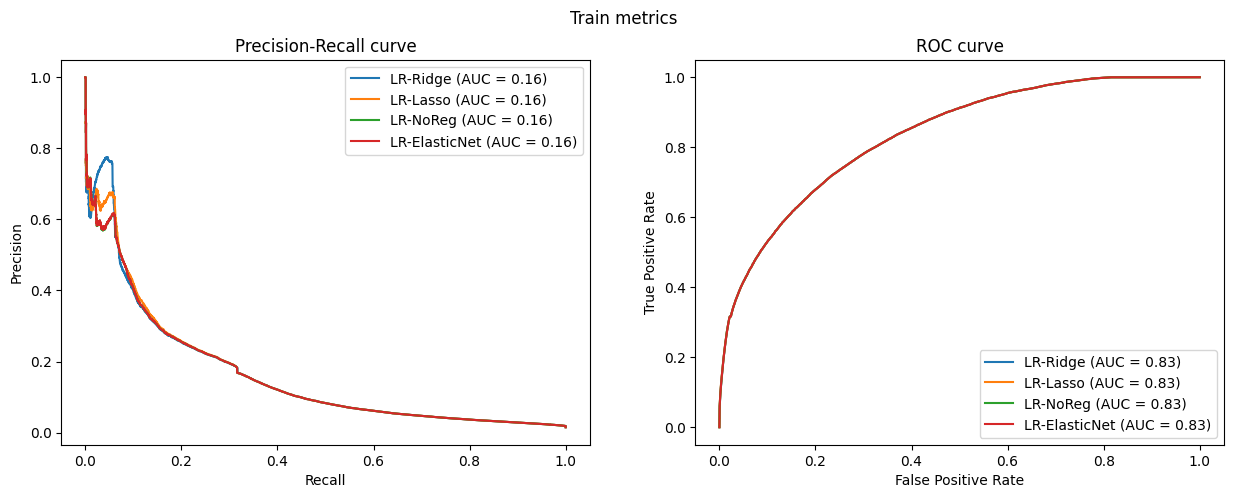

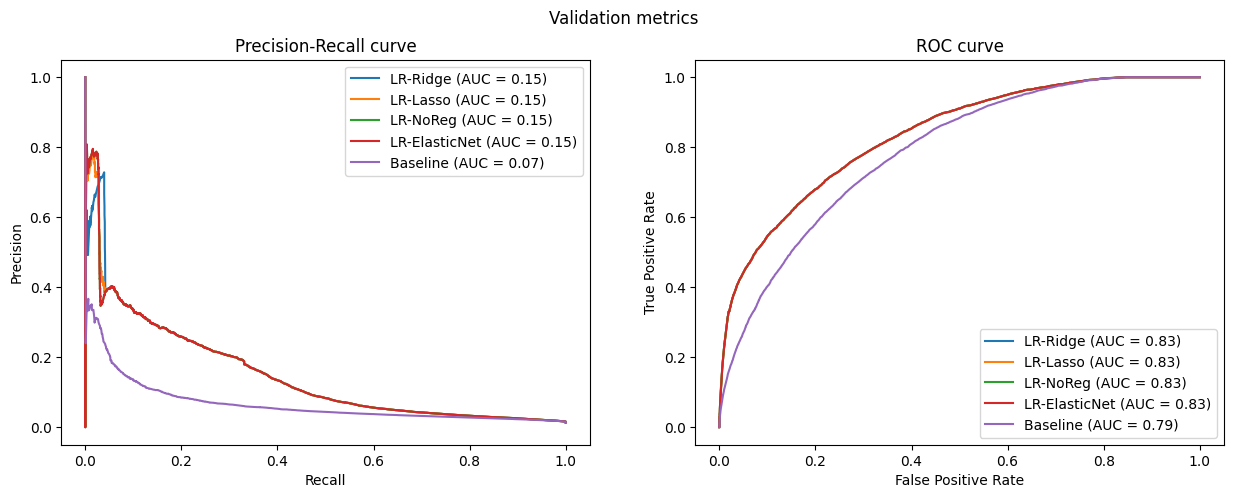

In [21]:
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 5))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))
fig2.suptitle("Validation metrics")


lrs = [
    Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(penalty="l2", C=1e-6)),
        ]
    ),
    Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(penalty="l1", C=1e-4, solver="saga")),
        ]
    ),
    Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(penalty=None)),
        ]
    ),
    Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            (
                "classifier",
                LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5),
            ),
        ]
    ),
]
names = ["LR-Ridge", "LR-Lasso", "LR-NoReg", "LR-ElasticNet"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[important_cols], y_train)
    train_proba = lr.predict_proba(X_train[important_cols])[:, 1]
    plot_metrics(f"{name}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1))

    val_proba = lr.predict_proba(X_val[important_cols])[:, 1]
    plot_metrics(f"{name}", val_proba, y_val, figure=(fig2, ax2))


plot_metrics(
    f"Baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[target],
    figure=(fig2, ax2),
)

- As shown by the results, we can significantly simplify the model without compromising its performance. The model achieves comparable results to the previous versions that included all features. Also, as we have shown before, further regularization doesn't improve the model.


### Categorical encoding: One hot enconding

In [26]:
for col in categorical_cols:
    unique_values = df_selected[col].unique()
    print(f"{col} has {len(unique_values)} unique values")

product_type has 62 unique values
vendor has 264 unique values


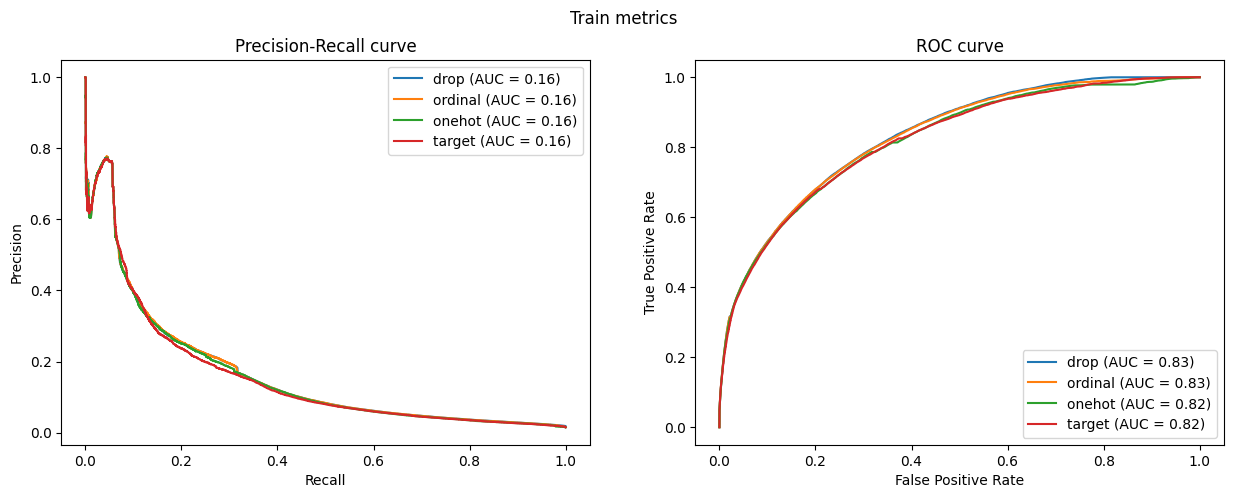

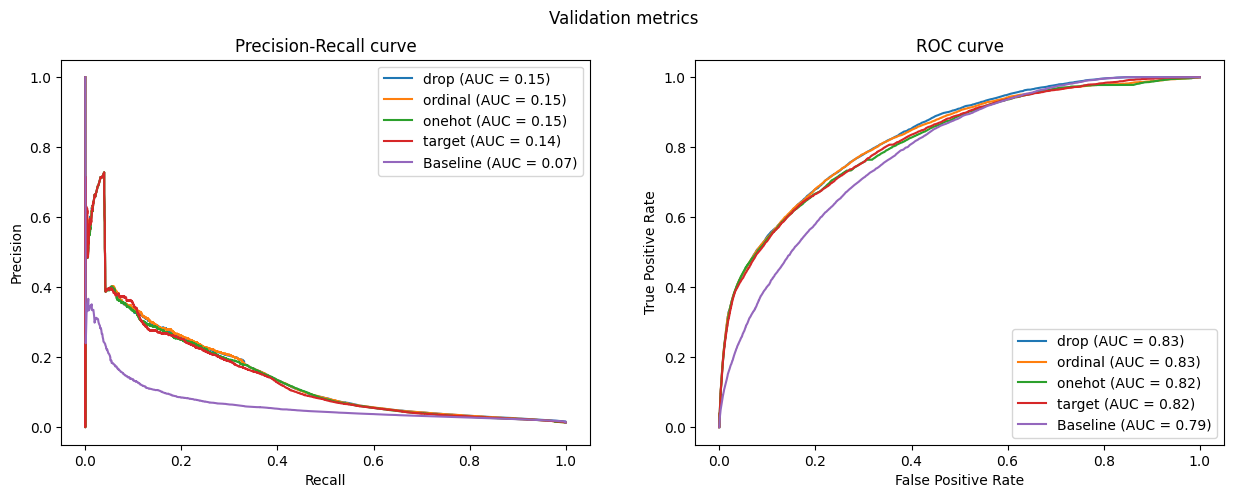

In [31]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "onehot",
        OneHotEncoder(handle_unknown="ignore", max_categories=15, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous")),
]

fig1, ax1 = plt.subplots(1, 2, figsize=(15, 5))
fig1.suptitle("Train metrics")
fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))
fig2.suptitle("Validation metrics")

extended_cols = important_cols + categorical_cols

for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", important_cols),
            ("cat", categorical_preprocessor, categorical_cols),
        ]
    )
    lr = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(penalty="l2", C=1e-6)),
        ]
    )
    lr.fit(X_train[extended_cols], y_train)
    train_proba = lr.predict_proba(X_train[extended_cols])[:, 1]
    plot_metrics(name, y_pred=train_proba, y_test=y_train, figure=(fig1, ax1))
    val_proba = lr.predict_proba(X_val[extended_cols])[:, 1]
    plot_metrics(name, val_proba, y_val, figure=(fig2, ax2))
plot_metrics(
    f"Baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[target],
    figure=(fig2, ax2),
)

As there were only two categorical variables, it makes sense that they don't affect the model that much.

Let's try now to compare the best model we've gotten so far against the test set.

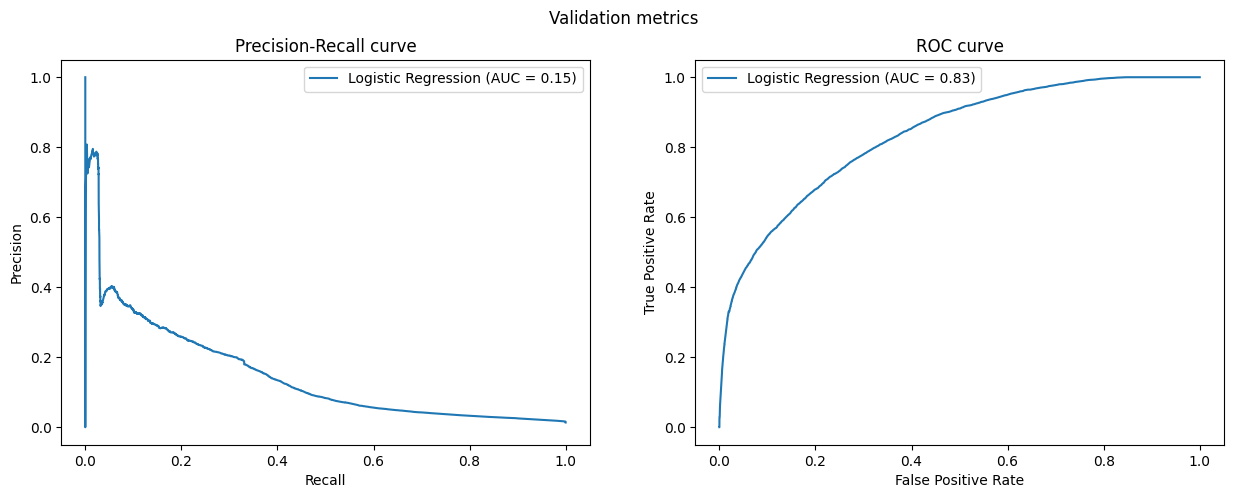

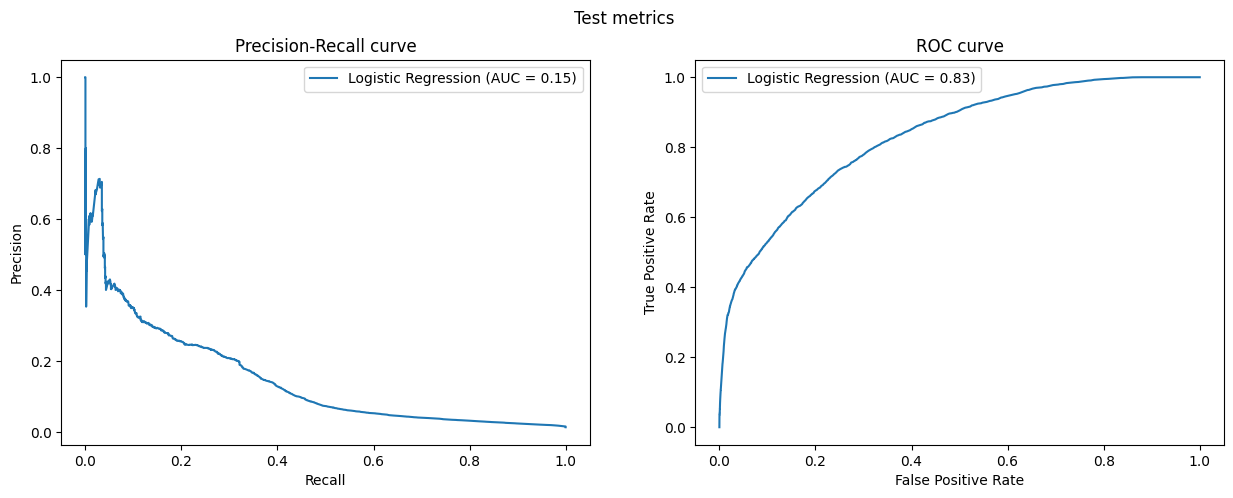

In [22]:
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 5))
fig1.suptitle("Validation metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))
fig2.suptitle("Test metrics")
lr = Pipeline(
    steps=[("scaler", StandardScaler()), ("classifier", LogisticRegression())]
)
lr.fit(X_train[important_cols], y_train)
val_proba = lr.predict_proba(X_val[important_cols])[:, 1]
plot_metrics("Logistic Regression", val_proba, y_val, figure=(fig1, ax1))
test_proba = lr.predict_proba(X_test[important_cols])[:, 1]
plot_metrics(
    "Logistic Regression", y_pred=test_proba, y_test=y_test, figure=(fig2, ax2)
)

As we have seen, the model is not overfitting (we're getting the same results in the validation and test datasets), so we can trust the results we are getting from the validation set.